<a href="https://colab.research.google.com/github/Vamshika09/GPT-2_like/blob/main/GPT2_like.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy portalocker --quiet
!pip install torch==2.3.0 --quiet
!pip install torchtext==0.18 --quiet
!pip install torchdata==0.8.0 --quiet
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!pip install tokenizers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import spacy
import os

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from datasets import load_dataset

/usr/local/lib/python3.11/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
torch.manual_seed(42)  # For reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
data = dataset["train"]['text']

data = [line for line in data if line.strip() != ""]
train_size = int(0.9*len(data))
train_data, valid_data = data[:train_size], data[(len(data)-train_size):]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from tokenizers.normalizers import Lowercase, Strip

In [ ]:
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.normalizer = Lowercase()
trainer = BpeTrainer(
    vocab_size = 32000,
    min_frequency = 3,
    special_tokens = ["[PAD]","[UNK]","[MASK]","[CLS]","[SEP]"]
)
tokenizer.train_from_iterator(train_data, trainer)
tokenizer.save("BPE_tokenizer.json")

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        encoding = self.tokenizer.encode(data)

        input_ids = torch.tensor(encoding.ids[:self.max_length] + [0] * (self.max_length - len(encoding.ids)))

        return input_ids


In [ ]:
batch_size = 16
max_seq_length = 128

train_dataset = TextDataset(train_data, tokenizer, max_seq_length)
valid_dataset = TextDataset(valid_data, tokenizer, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Embeddings(nn.Module):
  def __init__(self, vocab_size, max_seq_len, embedding_size):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, embedding_size)
    self.pos_embedding = nn.Embedding(max_seq_len, embedding_size)

  def forward(self, x):
    sequence_len = x.shape[1]
    positions = torch.arange(0, sequence_len, device = x.device)
    positions = positions.unsqueeze(0).expand(x.shape[0], -1)
    return self.token_embedding(x) + self.pos_embedding(positions)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_size, num_heads):
        super().__init__()
        self.multi_head_attn = nn.MultiheadAttention(embed_dim=embedding_size, num_heads=num_heads, batch_first=True)
        self.W_q = nn.Linear(embedding_size, embedding_size)
        self.W_k = nn.Linear(embedding_size, embedding_size)
        self.W_v = nn.Linear(embedding_size, embedding_size)


    def forward(self, x):
        batch_size, seq_length, _ = x.shape

        query = self.W_q(x)
        key = self.W_k(x)
        value = self.W_v(x)


        mask = torch.triu(torch.full((seq_length, seq_length), float('-inf')), diagonal=1).to(x.device)

        attn,_ = self.multi_head_attn(query, key, value, attn_mask=mask)
        return attn

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        return self.linear2(self.dropout(self.gelu(self.linear1(x))))

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm1(x)
        attn = self.self_attn(x)
        x = x + self.dropout(attn)
        x = self.layer_norm2(x)
        feed_forward = self.feed_forward(x)
        x = x + self.dropout(feed_forward)
        return x

In [ ]:
class GPT2(nn.Module):
    def __init__(self, vocab_size, max_seq_len, d_model, N, n_heads, d_ff, dropout, pad_idx):
        super().__init__()

        self.embedding = Embeddings(vocab_size, max_seq_len, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(N)])
        self.ln_f = nn.LayerNorm(d_model)
        self.out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

        # Initialization
        self.init_weights()
        self.pad_idx = pad_idx

    def init_weights(self):
        """Initialize parameters with Glorot / fan_avg"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        x = self.embedding(x)

        for layer in self.layers:
            x = layer(x)

        x = self.ln_f(x)
        output = self.out(x)
        return output

GPT2-small

In [ ]:
vocab_size = 32000     # Size of vocabulary
d_model = 768          # Embedding dimension
N = 12                  # Number of decoder layers
num_heads = 12         # Number of attention heads
d_ff = 3072            # Dimension of feed forward networks
dropout = 0.1          # Dropout rate
pad_idx = 0            # Index of the padding token

model = GPT2(vocab_size, max_seq_length, d_model, N, num_heads, d_ff, dropout, pad_idx)

model = model.to(device)

In [ ]:
from transformers import get_scheduler

learning_rate = 1e-4
weight_decay = 0.1
warmup_steps = 250
epochs = 8
num_training_steps = 500
gradient_accumulation_steps = 16
log_interval = 100

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)
criterion = nn.CrossEntropyLoss()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Training Epoch 1:   7%|▋         | 100/1337 [00:49<10:19,  2.00it/s]

Step [100/1337], Train Loss: 10.4541


Training Epoch 1:  15%|█▍        | 200/1337 [01:41<10:22,  1.83it/s]

Step [200/1337], Train Loss: 10.1475


Training Epoch 1:  22%|██▏       | 300/1337 [02:35<09:02,  1.91it/s]

Step [300/1337], Train Loss: 9.8163


Training Epoch 1:  30%|██▉       | 400/1337 [03:29<08:44,  1.79it/s]

Step [400/1337], Train Loss: 9.5231


Training Epoch 1:  37%|███▋      | 500/1337 [04:23<07:33,  1.85it/s]

Step [500/1337], Train Loss: 9.2587


Training Epoch 1:  45%|████▍     | 600/1337 [05:17<06:37,  1.85it/s]

Step [600/1337], Train Loss: 9.0283


Training Epoch 1:  52%|█████▏    | 700/1337 [06:11<05:42,  1.86it/s]

Step [700/1337], Train Loss: 8.8362


Training Epoch 1:  60%|█████▉    | 800/1337 [07:04<04:56,  1.81it/s]

Step [800/1337], Train Loss: 8.6604


Training Epoch 1:  67%|██████▋   | 900/1337 [07:57<03:55,  1.86it/s]

Step [900/1337], Train Loss: 8.5035


Training Epoch 1:  75%|███████▍  | 1000/1337 [08:51<02:58,  1.89it/s]

Step [1000/1337], Train Loss: 8.3744


Training Epoch 1:  82%|████████▏ | 1100/1337 [09:45<02:06,  1.88it/s]

Step [1100/1337], Train Loss: 8.2490


Training Epoch 1:  90%|████████▉ | 1200/1337 [10:38<01:15,  1.81it/s]

Step [1200/1337], Train Loss: 8.1262


Training Epoch 1:  97%|█████████▋| 1300/1337 [11:31<00:19,  1.87it/s]

Step [1300/1337], Train Loss: 8.0055


Testing Epoch 1:   8%|▊         | 101/1337 [00:18<03:44,  5.51it/s]

Step [100/1337], Validation Loss: 5.9701


Testing Epoch 1:  15%|█▌        | 201/1337 [00:36<03:27,  5.48it/s]

Step [200/1337], Validation Loss: 6.2613


Testing Epoch 1:  23%|██▎       | 301/1337 [00:54<03:07,  5.52it/s]

Step [300/1337], Validation Loss: 6.2679


Testing Epoch 1:  30%|██▉       | 401/1337 [01:12<02:49,  5.53it/s]

Step [400/1337], Validation Loss: 6.2509


Testing Epoch 1:  37%|███▋      | 501/1337 [01:31<02:32,  5.49it/s]

Step [500/1337], Validation Loss: 6.3105


Testing Epoch 1:  45%|████▍     | 601/1337 [01:49<02:13,  5.50it/s]

Step [600/1337], Validation Loss: 6.3336


Testing Epoch 1:  52%|█████▏    | 701/1337 [02:07<01:55,  5.49it/s]

Step [700/1337], Validation Loss: 6.3277


Testing Epoch 1:  60%|█████▉    | 801/1337 [02:25<01:37,  5.51it/s]

Step [800/1337], Validation Loss: 6.3241


Testing Epoch 1:  67%|██████▋   | 901/1337 [02:43<01:18,  5.52it/s]

Step [900/1337], Validation Loss: 6.3020


Testing Epoch 1:  75%|███████▍  | 1001/1337 [03:02<01:00,  5.51it/s]

Step [1000/1337], Validation Loss: 6.3255


Testing Epoch 1:  82%|████████▏ | 1101/1337 [03:20<00:43,  5.47it/s]

Step [1100/1337], Validation Loss: 6.3200


Testing Epoch 1:  90%|████████▉ | 1201/1337 [03:38<00:24,  5.50it/s]

Step [1200/1337], Validation Loss: 6.3527


Testing Epoch 1:  97%|█████████▋| 1301/1337 [03:56<00:06,  5.48it/s]

Step [1300/1337], Validation Loss: 6.3634


Testing Epoch 1: 100%|██████████| 1337/1337 [04:03<00:00,  5.50it/s]


Epoch 1: Train Loss = 7.9618, Test Loss = 6.3672


Training Epoch 2:   7%|▋         | 100/1337 [00:53<11:04,  1.86it/s]

Step [100/1337], Train Loss: 6.4313


Training Epoch 2:  15%|█▍        | 200/1337 [01:47<10:05,  1.88it/s]

Step [200/1337], Train Loss: 6.3057


Training Epoch 2:  22%|██▏       | 300/1337 [02:40<09:08,  1.89it/s]

Step [300/1337], Train Loss: 6.1780


Training Epoch 2:  30%|██▉       | 400/1337 [03:34<08:44,  1.79it/s]

Step [400/1337], Train Loss: 6.0502


Training Epoch 2:  37%|███▋      | 500/1337 [04:28<07:28,  1.87it/s]

Step [500/1337], Train Loss: 5.9295


Training Epoch 2:  45%|████▍     | 600/1337 [05:23<06:37,  1.85it/s]

Step [600/1337], Train Loss: 5.8145


Training Epoch 2:  52%|█████▏    | 700/1337 [06:16<05:38,  1.88it/s]

Step [700/1337], Train Loss: 5.7048


Training Epoch 2:  60%|█████▉    | 800/1337 [07:10<05:01,  1.78it/s]

Step [800/1337], Train Loss: 5.5855


Training Epoch 2:  67%|██████▋   | 900/1337 [08:04<03:57,  1.84it/s]

Step [900/1337], Train Loss: 5.4666


Training Epoch 2:  75%|███████▍  | 1000/1337 [08:58<03:01,  1.85it/s]

Step [1000/1337], Train Loss: 5.3590


Training Epoch 2:  82%|████████▏ | 1100/1337 [09:52<02:07,  1.86it/s]

Step [1100/1337], Train Loss: 5.2683


Training Epoch 2:  90%|████████▉ | 1200/1337 [10:46<01:17,  1.78it/s]

Step [1200/1337], Train Loss: 5.1828


Training Epoch 2:  97%|█████████▋| 1300/1337 [11:40<00:19,  1.88it/s]

Step [1300/1337], Train Loss: 5.0971


Testing Epoch 2:   8%|▊         | 101/1337 [00:18<03:44,  5.51it/s]

Step [100/1337], Validation Loss: 3.5997


Testing Epoch 2:  15%|█▌        | 201/1337 [00:36<03:27,  5.47it/s]

Step [200/1337], Validation Loss: 3.9150


Testing Epoch 2:  23%|██▎       | 301/1337 [00:54<03:09,  5.48it/s]

Step [300/1337], Validation Loss: 3.9160


Testing Epoch 2:  30%|██▉       | 401/1337 [01:12<02:51,  5.46it/s]

Step [400/1337], Validation Loss: 3.8929


Testing Epoch 2:  37%|███▋      | 501/1337 [01:31<02:32,  5.48it/s]

Step [500/1337], Validation Loss: 3.9561


Testing Epoch 2:  45%|████▍     | 601/1337 [01:49<02:14,  5.46it/s]

Step [600/1337], Validation Loss: 3.9803


Testing Epoch 2:  52%|█████▏    | 701/1337 [02:07<01:54,  5.53it/s]

Step [700/1337], Validation Loss: 3.9734


Testing Epoch 2:  60%|█████▉    | 801/1337 [02:25<01:37,  5.50it/s]

Step [800/1337], Validation Loss: 3.9685


Testing Epoch 2:  67%|██████▋   | 901/1337 [02:43<01:20,  5.45it/s]

Step [900/1337], Validation Loss: 3.9453


Testing Epoch 2:  75%|███████▍  | 1001/1337 [03:02<01:00,  5.52it/s]

Step [1000/1337], Validation Loss: 3.9704


Testing Epoch 2:  82%|████████▏ | 1101/1337 [03:20<00:42,  5.52it/s]

Step [1100/1337], Validation Loss: 3.9648


Testing Epoch 2:  90%|████████▉ | 1201/1337 [03:38<00:24,  5.46it/s]

Step [1200/1337], Validation Loss: 4.0020


Testing Epoch 2:  97%|█████████▋| 1301/1337 [03:56<00:06,  5.49it/s]

Step [1300/1337], Validation Loss: 4.0182


Testing Epoch 2: 100%|██████████| 1337/1337 [04:03<00:00,  5.49it/s]


Epoch 2: Train Loss = 5.0696, Test Loss = 4.0244


Training Epoch 3:   7%|▋         | 100/1337 [00:53<11:08,  1.85it/s]

Step [100/1337], Train Loss: 4.0110


Training Epoch 3:  15%|█▍        | 200/1337 [01:47<10:05,  1.88it/s]

Step [200/1337], Train Loss: 3.9813


Training Epoch 3:  22%|██▏       | 300/1337 [02:41<09:14,  1.87it/s]

Step [300/1337], Train Loss: 3.9949


Training Epoch 3:  30%|██▉       | 400/1337 [03:34<08:37,  1.81it/s]

Step [400/1337], Train Loss: 3.9726


Training Epoch 3:  37%|███▋      | 500/1337 [04:28<07:27,  1.87it/s]

Step [500/1337], Train Loss: 3.9656


Training Epoch 3:  45%|████▍     | 600/1337 [05:21<06:38,  1.85it/s]

Step [600/1337], Train Loss: 3.9729


Training Epoch 3:  52%|█████▏    | 700/1337 [06:15<05:37,  1.89it/s]

Step [700/1337], Train Loss: 3.9656


Training Epoch 3:  60%|█████▉    | 800/1337 [07:09<04:57,  1.81it/s]

Step [800/1337], Train Loss: 3.9498


Training Epoch 3:  67%|██████▋   | 900/1337 [08:03<03:56,  1.84it/s]

Step [900/1337], Train Loss: 3.9485


Training Epoch 3:  75%|███████▍  | 1000/1337 [08:56<03:02,  1.85it/s]

Step [1000/1337], Train Loss: 3.9325


Training Epoch 3:  82%|████████▏ | 1100/1337 [09:50<02:06,  1.88it/s]

Step [1100/1337], Train Loss: 3.9208


Training Epoch 3:  90%|████████▉ | 1200/1337 [10:44<01:15,  1.81it/s]

Step [1200/1337], Train Loss: 3.9205


Training Epoch 3:  97%|█████████▋| 1300/1337 [11:37<00:20,  1.84it/s]

Step [1300/1337], Train Loss: 3.9148


Testing Epoch 3:   8%|▊         | 101/1337 [00:18<03:44,  5.50it/s]

Step [100/1337], Validation Loss: 3.5648


Testing Epoch 3:  15%|█▌        | 201/1337 [00:36<03:26,  5.50it/s]

Step [200/1337], Validation Loss: 3.8944


Testing Epoch 3:  23%|██▎       | 301/1337 [00:54<03:08,  5.50it/s]

Step [300/1337], Validation Loss: 3.8963


Testing Epoch 3:  30%|██▉       | 401/1337 [01:12<02:49,  5.52it/s]

Step [400/1337], Validation Loss: 3.8750


Testing Epoch 3:  37%|███▋      | 501/1337 [01:31<02:31,  5.52it/s]

Step [500/1337], Validation Loss: 3.9416


Testing Epoch 3:  45%|████▍     | 601/1337 [01:49<02:13,  5.53it/s]

Step [600/1337], Validation Loss: 3.9668


Testing Epoch 3:  52%|█████▏    | 701/1337 [02:07<01:55,  5.52it/s]

Step [700/1337], Validation Loss: 3.9599


Testing Epoch 3:  60%|█████▉    | 801/1337 [02:25<01:36,  5.55it/s]

Step [800/1337], Validation Loss: 3.9547


Testing Epoch 3:  67%|██████▋   | 901/1337 [02:43<01:19,  5.50it/s]

Step [900/1337], Validation Loss: 3.9304


Testing Epoch 3:  75%|███████▍  | 1001/1337 [03:01<01:00,  5.53it/s]

Step [1000/1337], Validation Loss: 3.9564


Testing Epoch 3:  82%|████████▏ | 1101/1337 [03:20<00:42,  5.57it/s]

Step [1100/1337], Validation Loss: 3.9511


Testing Epoch 3:  90%|████████▉ | 1201/1337 [03:38<00:24,  5.52it/s]

Step [1200/1337], Validation Loss: 3.9894


Testing Epoch 3:  97%|█████████▋| 1301/1337 [03:56<00:06,  5.49it/s]

Step [1300/1337], Validation Loss: 4.0054


Testing Epoch 3: 100%|██████████| 1337/1337 [04:02<00:00,  5.51it/s]


Epoch 3: Train Loss = 3.9153, Test Loss = 4.0112


Training Epoch 4:   7%|▋         | 100/1337 [00:53<11:04,  1.86it/s]

Step [100/1337], Train Loss: 4.0400


Training Epoch 4:  15%|█▍        | 200/1337 [01:46<10:03,  1.89it/s]

Step [200/1337], Train Loss: 3.9551


Training Epoch 4:  22%|██▏       | 300/1337 [02:40<09:12,  1.88it/s]

Step [300/1337], Train Loss: 3.9091


Training Epoch 4:  30%|██▉       | 400/1337 [03:34<08:42,  1.79it/s]

Step [400/1337], Train Loss: 3.8934


Training Epoch 4:  37%|███▋      | 500/1337 [04:28<07:35,  1.84it/s]

Step [500/1337], Train Loss: 3.8860


Training Epoch 4:  45%|████▍     | 600/1337 [05:22<06:34,  1.87it/s]

Step [600/1337], Train Loss: 3.8644


Training Epoch 4:  52%|█████▏    | 700/1337 [06:16<05:42,  1.86it/s]

Step [700/1337], Train Loss: 3.8669


Training Epoch 4:  60%|█████▉    | 800/1337 [07:09<04:56,  1.81it/s]

Step [800/1337], Train Loss: 3.8687


Training Epoch 4:  67%|██████▋   | 900/1337 [08:03<03:58,  1.83it/s]

Step [900/1337], Train Loss: 3.8589


Training Epoch 4:  75%|███████▍  | 1000/1337 [08:57<02:59,  1.88it/s]

Step [1000/1337], Train Loss: 3.8655


Training Epoch 4:  82%|████████▏ | 1100/1337 [09:50<02:07,  1.86it/s]

Step [1100/1337], Train Loss: 3.8673


Training Epoch 4:  90%|████████▉ | 1200/1337 [10:44<01:15,  1.81it/s]

Step [1200/1337], Train Loss: 3.8674


Training Epoch 4:  97%|█████████▋| 1300/1337 [11:38<00:19,  1.86it/s]

Step [1300/1337], Train Loss: 3.8732


Testing Epoch 4:   8%|▊         | 101/1337 [00:18<03:46,  5.45it/s]

Step [100/1337], Validation Loss: 3.4475


Testing Epoch 4:  15%|█▌        | 201/1337 [00:36<03:25,  5.54it/s]

Step [200/1337], Validation Loss: 3.7623


Testing Epoch 4:  23%|██▎       | 301/1337 [00:54<03:09,  5.47it/s]

Step [300/1337], Validation Loss: 3.7622


Testing Epoch 4:  30%|██▉       | 401/1337 [01:12<02:50,  5.50it/s]

Step [400/1337], Validation Loss: 3.7386


Testing Epoch 4:  37%|███▋      | 501/1337 [01:31<02:31,  5.51it/s]

Step [500/1337], Validation Loss: 3.8017


Testing Epoch 4:  45%|████▍     | 601/1337 [01:49<02:14,  5.49it/s]

Step [600/1337], Validation Loss: 3.8256


Testing Epoch 4:  52%|█████▏    | 701/1337 [02:07<01:56,  5.47it/s]

Step [700/1337], Validation Loss: 3.8190


Testing Epoch 4:  60%|█████▉    | 801/1337 [02:25<01:38,  5.46it/s]

Step [800/1337], Validation Loss: 3.8135


Testing Epoch 4:  67%|██████▋   | 901/1337 [02:43<01:19,  5.46it/s]

Step [900/1337], Validation Loss: 3.7908


Testing Epoch 4:  75%|███████▍  | 1001/1337 [03:02<01:00,  5.53it/s]

Step [1000/1337], Validation Loss: 3.8156


Testing Epoch 4:  82%|████████▏ | 1101/1337 [03:20<00:42,  5.53it/s]

Step [1100/1337], Validation Loss: 3.8105


Testing Epoch 4:  90%|████████▉ | 1201/1337 [03:38<00:24,  5.50it/s]

Step [1200/1337], Validation Loss: 3.8480


Testing Epoch 4:  97%|█████████▋| 1301/1337 [03:56<00:06,  5.46it/s]

Step [1300/1337], Validation Loss: 3.8656


Testing Epoch 4: 100%|██████████| 1337/1337 [04:03<00:00,  5.50it/s]


Epoch 4: Train Loss = 3.8707, Test Loss = 3.8722


Training Epoch 5:   7%|▋         | 100/1337 [00:53<11:03,  1.87it/s]

Step [100/1337], Train Loss: 3.9118


Training Epoch 5:  15%|█▍        | 200/1337 [01:47<10:13,  1.85it/s]

Step [200/1337], Train Loss: 3.8574


Training Epoch 5:  22%|██▏       | 300/1337 [02:41<09:18,  1.86it/s]

Step [300/1337], Train Loss: 3.7961


Training Epoch 5:  30%|██▉       | 400/1337 [03:34<08:35,  1.82it/s]

Step [400/1337], Train Loss: 3.7319


Training Epoch 5:  37%|███▋      | 500/1337 [04:28<07:31,  1.85it/s]

Step [500/1337], Train Loss: 3.6833


Training Epoch 5:  45%|████▍     | 600/1337 [05:22<06:33,  1.87it/s]

Step [600/1337], Train Loss: 3.6550


Training Epoch 5:  52%|█████▏    | 700/1337 [06:16<05:43,  1.86it/s]

Step [700/1337], Train Loss: 3.5999


Training Epoch 5:  60%|█████▉    | 800/1337 [07:10<04:57,  1.80it/s]

Step [800/1337], Train Loss: 3.5843


Training Epoch 5:  67%|██████▋   | 900/1337 [08:04<03:54,  1.87it/s]

Step [900/1337], Train Loss: 3.5554


Training Epoch 5:  75%|███████▍  | 1000/1337 [08:57<03:00,  1.87it/s]

Step [1000/1337], Train Loss: 3.5196


Training Epoch 5:  82%|████████▏ | 1100/1337 [09:51<02:06,  1.88it/s]

Step [1100/1337], Train Loss: 3.4934


Training Epoch 5:  90%|████████▉ | 1200/1337 [10:45<01:16,  1.79it/s]

Step [1200/1337], Train Loss: 3.4756


Training Epoch 5:  97%|█████████▋| 1300/1337 [11:39<00:20,  1.84it/s]

Step [1300/1337], Train Loss: 3.4582


Testing Epoch 5:   8%|▊         | 101/1337 [00:18<03:45,  5.49it/s]

Step [100/1337], Validation Loss: 2.8181


Testing Epoch 5:  15%|█▌        | 201/1337 [00:36<03:28,  5.44it/s]

Step [200/1337], Validation Loss: 3.0686


Testing Epoch 5:  23%|██▎       | 301/1337 [00:54<03:08,  5.49it/s]

Step [300/1337], Validation Loss: 3.0649


Testing Epoch 5:  30%|██▉       | 401/1337 [01:12<02:50,  5.50it/s]

Step [400/1337], Validation Loss: 3.0446


Testing Epoch 5:  37%|███▋      | 501/1337 [01:31<02:31,  5.50it/s]

Step [500/1337], Validation Loss: 3.0946


Testing Epoch 5:  45%|████▍     | 601/1337 [01:49<02:13,  5.52it/s]

Step [600/1337], Validation Loss: 3.1139


Testing Epoch 5:  52%|█████▏    | 701/1337 [02:07<01:55,  5.51it/s]

Step [700/1337], Validation Loss: 3.1085


Testing Epoch 5:  60%|█████▉    | 801/1337 [02:25<01:37,  5.49it/s]

Step [800/1337], Validation Loss: 3.1040


Testing Epoch 5:  67%|██████▋   | 901/1337 [02:44<01:19,  5.50it/s]

Step [900/1337], Validation Loss: 3.0859


Testing Epoch 5:  75%|███████▍  | 1001/1337 [03:02<01:00,  5.56it/s]

Step [1000/1337], Validation Loss: 3.1056


Testing Epoch 5:  82%|████████▏ | 1101/1337 [03:20<00:42,  5.50it/s]

Step [1100/1337], Validation Loss: 3.1013


Testing Epoch 5:  90%|████████▉ | 1201/1337 [03:38<00:24,  5.48it/s]

Step [1200/1337], Validation Loss: 3.1322


Testing Epoch 5:  97%|█████████▋| 1301/1337 [03:56<00:06,  5.51it/s]

Step [1300/1337], Validation Loss: 3.1482


Testing Epoch 5: 100%|██████████| 1337/1337 [04:03<00:00,  5.49it/s]


Epoch 5: Train Loss = 3.4463, Test Loss = 3.1543


Training Epoch 6:   7%|▋         | 100/1337 [00:54<11:06,  1.85it/s]

Step [100/1337], Train Loss: 3.1694


Training Epoch 6:  15%|█▍        | 200/1337 [01:47<10:03,  1.88it/s]

Step [200/1337], Train Loss: 3.1845


Training Epoch 6:  22%|██▏       | 300/1337 [02:41<09:11,  1.88it/s]

Step [300/1337], Train Loss: 3.1357


Training Epoch 6:  30%|██▉       | 400/1337 [03:34<08:38,  1.81it/s]

Step [400/1337], Train Loss: 3.1174


Training Epoch 6:  37%|███▋      | 500/1337 [04:28<07:36,  1.84it/s]

Step [500/1337], Train Loss: 3.0866


Training Epoch 6:  45%|████▍     | 600/1337 [05:22<06:38,  1.85it/s]

Step [600/1337], Train Loss: 3.0795


Training Epoch 6:  52%|█████▏    | 700/1337 [06:16<05:39,  1.88it/s]

Step [700/1337], Train Loss: 3.0859


Training Epoch 6:  60%|█████▉    | 800/1337 [07:10<05:00,  1.79it/s]

Step [800/1337], Train Loss: 3.0879


Training Epoch 6:  67%|██████▋   | 900/1337 [08:04<03:58,  1.84it/s]

Step [900/1337], Train Loss: 3.0717


Training Epoch 6:  75%|███████▍  | 1000/1337 [08:58<03:00,  1.87it/s]

Step [1000/1337], Train Loss: 3.0535


Training Epoch 6:  82%|████████▏ | 1100/1337 [09:51<02:05,  1.88it/s]

Step [1100/1337], Train Loss: 3.0649


Training Epoch 6:  90%|████████▉ | 1200/1337 [10:46<01:15,  1.81it/s]

Step [1200/1337], Train Loss: 3.0589


Training Epoch 6:  97%|█████████▋| 1300/1337 [11:40<00:20,  1.84it/s]

Step [1300/1337], Train Loss: 3.0558


Testing Epoch 6:   8%|▊         | 101/1337 [00:18<03:43,  5.52it/s]

Step [100/1337], Validation Loss: 2.6962


Testing Epoch 6:  15%|█▌        | 201/1337 [00:36<03:27,  5.48it/s]

Step [200/1337], Validation Loss: 2.9363


Testing Epoch 6:  23%|██▎       | 301/1337 [00:54<03:08,  5.50it/s]

Step [300/1337], Validation Loss: 2.9327


Testing Epoch 6:  30%|██▉       | 401/1337 [01:12<02:51,  5.47it/s]

Step [400/1337], Validation Loss: 2.9128


Testing Epoch 6:  37%|███▋      | 501/1337 [01:31<02:31,  5.50it/s]

Step [500/1337], Validation Loss: 2.9607


Testing Epoch 6:  45%|████▍     | 601/1337 [01:49<02:13,  5.51it/s]

Step [600/1337], Validation Loss: 2.9790


Testing Epoch 6:  52%|█████▏    | 701/1337 [02:07<01:55,  5.51it/s]

Step [700/1337], Validation Loss: 2.9736


Testing Epoch 6:  60%|█████▉    | 801/1337 [02:25<01:37,  5.53it/s]

Step [800/1337], Validation Loss: 2.9691


Testing Epoch 6:  67%|██████▋   | 901/1337 [02:44<01:19,  5.50it/s]

Step [900/1337], Validation Loss: 2.9519


Testing Epoch 6:  75%|███████▍  | 1001/1337 [03:02<01:00,  5.51it/s]

Step [1000/1337], Validation Loss: 2.9707


Testing Epoch 6:  82%|████████▏ | 1101/1337 [03:20<00:42,  5.50it/s]

Step [1100/1337], Validation Loss: 2.9667


Testing Epoch 6:  90%|████████▉ | 1201/1337 [03:38<00:24,  5.47it/s]

Step [1200/1337], Validation Loss: 2.9965


Testing Epoch 6:  97%|█████████▋| 1301/1337 [03:57<00:06,  5.49it/s]

Step [1300/1337], Validation Loss: 3.0124


Testing Epoch 6: 100%|██████████| 1337/1337 [04:03<00:00,  5.49it/s]


Epoch 6: Train Loss = 3.0555, Test Loss = 3.0184


Training Epoch 7:   7%|▋         | 100/1337 [00:53<11:02,  1.87it/s]

Step [100/1337], Train Loss: 3.0115


Training Epoch 7:  15%|█▍        | 200/1337 [01:46<10:05,  1.88it/s]

Step [200/1337], Train Loss: 2.9811


Training Epoch 7:  22%|██▏       | 300/1337 [02:40<09:19,  1.85it/s]

Step [300/1337], Train Loss: 2.9900


Training Epoch 7:  30%|██▉       | 400/1337 [03:34<08:45,  1.78it/s]

Step [400/1337], Train Loss: 2.9999


Training Epoch 7:  37%|███▋      | 500/1337 [04:28<07:31,  1.85it/s]

Step [500/1337], Train Loss: 2.9915


Training Epoch 7:  45%|████▍     | 600/1337 [05:22<06:33,  1.87it/s]

Step [600/1337], Train Loss: 3.0189


Training Epoch 7:  52%|█████▏    | 700/1337 [06:16<05:40,  1.87it/s]

Step [700/1337], Train Loss: 3.0185


Training Epoch 7:  60%|█████▉    | 800/1337 [07:10<04:59,  1.79it/s]

Step [800/1337], Train Loss: 3.0190


Training Epoch 7:  67%|██████▋   | 900/1337 [08:04<03:53,  1.87it/s]

Step [900/1337], Train Loss: 3.0226


Training Epoch 7:  75%|███████▍  | 1000/1337 [08:58<03:02,  1.85it/s]

Step [1000/1337], Train Loss: 3.0221


Training Epoch 7:  82%|████████▏ | 1100/1337 [09:52<02:07,  1.86it/s]

Step [1100/1337], Train Loss: 3.0217


Training Epoch 7:  90%|████████▉ | 1200/1337 [10:46<01:15,  1.81it/s]

Step [1200/1337], Train Loss: 3.0192


Training Epoch 7:  97%|█████████▋| 1300/1337 [11:40<00:20,  1.84it/s]

Step [1300/1337], Train Loss: 3.0057


Testing Epoch 7:   8%|▊         | 101/1337 [00:18<03:45,  5.48it/s]

Step [100/1337], Validation Loss: 2.6301


Testing Epoch 7:  15%|█▌        | 201/1337 [00:36<03:27,  5.47it/s]

Step [200/1337], Validation Loss: 2.8641


Testing Epoch 7:  23%|██▎       | 301/1337 [00:54<03:08,  5.49it/s]

Step [300/1337], Validation Loss: 2.8602


Testing Epoch 7:  30%|██▉       | 401/1337 [01:12<02:49,  5.53it/s]

Step [400/1337], Validation Loss: 2.8405


Testing Epoch 7:  37%|███▋      | 501/1337 [01:31<02:32,  5.48it/s]

Step [500/1337], Validation Loss: 2.8871


Testing Epoch 7:  45%|████▍     | 601/1337 [01:49<02:14,  5.47it/s]

Step [600/1337], Validation Loss: 2.9048


Testing Epoch 7:  52%|█████▏    | 701/1337 [02:07<01:55,  5.50it/s]

Step [700/1337], Validation Loss: 2.8994


Testing Epoch 7:  60%|█████▉    | 801/1337 [02:25<01:37,  5.49it/s]

Step [800/1337], Validation Loss: 2.8949


Testing Epoch 7:  67%|██████▋   | 901/1337 [02:43<01:19,  5.48it/s]

Step [900/1337], Validation Loss: 2.8784


Testing Epoch 7:  75%|███████▍  | 1001/1337 [03:02<01:00,  5.52it/s]

Step [1000/1337], Validation Loss: 2.8965


Testing Epoch 7:  82%|████████▏ | 1101/1337 [03:20<00:43,  5.48it/s]

Step [1100/1337], Validation Loss: 2.8928


Testing Epoch 7:  90%|████████▉ | 1201/1337 [03:38<00:24,  5.49it/s]

Step [1200/1337], Validation Loss: 2.9220


Testing Epoch 7:  97%|█████████▋| 1301/1337 [03:56<00:06,  5.48it/s]

Step [1300/1337], Validation Loss: 2.9378


Testing Epoch 7: 100%|██████████| 1337/1337 [04:03<00:00,  5.49it/s]


Epoch 7: Train Loss = 3.0023, Test Loss = 2.9438


Training Epoch 8:   7%|▋         | 100/1337 [00:53<11:07,  1.85it/s]

Step [100/1337], Train Loss: 2.9738


Training Epoch 8:  15%|█▍        | 200/1337 [01:47<10:16,  1.84it/s]

Step [200/1337], Train Loss: 2.9691


Training Epoch 8:  22%|██▏       | 300/1337 [02:41<09:21,  1.85it/s]

Step [300/1337], Train Loss: 2.9595


Training Epoch 8:  30%|██▉       | 400/1337 [03:35<08:37,  1.81it/s]

Step [400/1337], Train Loss: 2.9339


Training Epoch 8:  37%|███▋      | 500/1337 [04:29<07:34,  1.84it/s]

Step [500/1337], Train Loss: 2.9595


Training Epoch 8:  45%|████▍     | 600/1337 [05:23<06:39,  1.85it/s]

Step [600/1337], Train Loss: 2.9736


Training Epoch 8:  52%|█████▏    | 700/1337 [06:17<05:45,  1.84it/s]

Step [700/1337], Train Loss: 2.9737


Training Epoch 8:  60%|█████▉    | 800/1337 [07:10<04:56,  1.81it/s]

Step [800/1337], Train Loss: 2.9772


Training Epoch 8:  67%|██████▋   | 900/1337 [08:04<03:55,  1.86it/s]

Step [900/1337], Train Loss: 2.9675


Training Epoch 8:  75%|███████▍  | 1000/1337 [08:58<02:59,  1.88it/s]

Step [1000/1337], Train Loss: 2.9685


Training Epoch 8:  82%|████████▏ | 1100/1337 [09:52<02:06,  1.88it/s]

Step [1100/1337], Train Loss: 2.9686


Training Epoch 8:  90%|████████▉ | 1200/1337 [10:45<01:16,  1.78it/s]

Step [1200/1337], Train Loss: 2.9675


Training Epoch 8:  97%|█████████▋| 1300/1337 [11:39<00:20,  1.83it/s]

Step [1300/1337], Train Loss: 2.9674


Testing Epoch 8:   8%|▊         | 101/1337 [00:18<03:45,  5.49it/s]

Step [100/1337], Validation Loss: 2.6731


Testing Epoch 8:  15%|█▌        | 201/1337 [00:36<03:25,  5.52it/s]

Step [200/1337], Validation Loss: 2.9096


Testing Epoch 8:  23%|██▎       | 301/1337 [00:54<03:08,  5.50it/s]

Step [300/1337], Validation Loss: 2.9072


Testing Epoch 8:  30%|██▉       | 401/1337 [01:12<02:51,  5.47it/s]

Step [400/1337], Validation Loss: 2.8889


Testing Epoch 8:  37%|███▋      | 501/1337 [01:31<02:32,  5.49it/s]

Step [500/1337], Validation Loss: 2.9364


Testing Epoch 8:  45%|████▍     | 601/1337 [01:49<02:14,  5.47it/s]

Step [600/1337], Validation Loss: 2.9541


Testing Epoch 8:  52%|█████▏    | 701/1337 [02:07<01:55,  5.48it/s]

Step [700/1337], Validation Loss: 2.9491


Testing Epoch 8:  60%|█████▉    | 801/1337 [02:25<01:37,  5.52it/s]

Step [800/1337], Validation Loss: 2.9446


Testing Epoch 8:  67%|██████▋   | 901/1337 [02:43<01:19,  5.50it/s]

Step [900/1337], Validation Loss: 2.9275


Testing Epoch 8:  75%|███████▍  | 1001/1337 [03:02<01:01,  5.49it/s]

Step [1000/1337], Validation Loss: 2.9464


Testing Epoch 8:  82%|████████▏ | 1101/1337 [03:20<00:42,  5.60it/s]

Step [1100/1337], Validation Loss: 2.9426


Testing Epoch 8:  90%|████████▉ | 1201/1337 [03:38<00:24,  5.50it/s]

Step [1200/1337], Validation Loss: 2.9721


Testing Epoch 8:  97%|█████████▋| 1301/1337 [03:56<00:06,  5.49it/s]

Step [1300/1337], Validation Loss: 2.9878


Testing Epoch 8: 100%|██████████| 1337/1337 [04:03<00:00,  5.49it/s]


Epoch 8: Train Loss = 2.9675, Test Loss = 2.9935


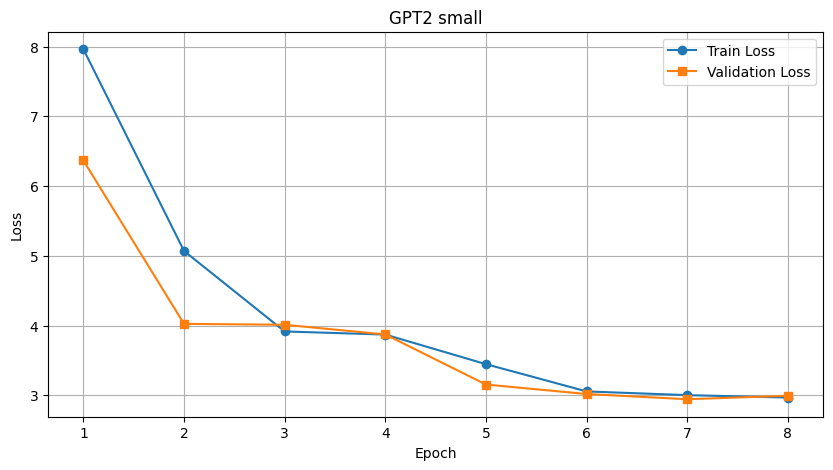

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    optimizer.zero_grad()

    for step, input_ids in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        input_ids = input_ids.to(device)
        outputs = model(input_ids)
        loss = criterion(outputs.view(-1, vocab_size), input_ids.view(-1)) / gradient_accumulation_steps

        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        train_loss += loss.item() * gradient_accumulation_steps

        if (step + 1) % log_interval == 0:
            avg_train_loss = train_loss / (step + 1)
            print(f"Step [{step+1}/{len(train_loader)}], Train Loss: {avg_train_loss:.4f}")

        del input_ids, outputs, loss
        torch.cuda.empty_cache()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for step, input_ids in enumerate(tqdm(valid_loader, desc=f"Testing Epoch {epoch+1}")):
            input_ids = input_ids.to(device)
            outputs = model(input_ids)
            loss = criterion(outputs.view(-1, vocab_size), input_ids.view(-1))

            valid_loss += loss.item()

            if (step + 1) % log_interval == 0:
                avg_valid_loss = valid_loss / (step + 1)
                print(f"Step [{step+1}/{len(valid_loader)}], Validation Loss: {avg_valid_loss:.4f}")

            del input_ids, outputs, loss
            torch.cuda.empty_cache()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_valid_loss:.4f}")

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GPT2 small")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_checkpoint = "model_epoch_8.pt"
model.load_state_dict(torch.load(model_checkpoint, map_location=device))
model.to(device)
model.eval()

GPT2(
  (embedding): Embeddings(
    (token_embedding): Embedding(32000, 768)
    (pos_embedding): Embedding(128, 768)
  )
  (layers): ModuleList(
    (0-11): 12 x DecoderLayer(
      (self_attn): MultiHeadAttention(
        (multi_head_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (gelu): GELU(approximate='none')
      )
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwis

In [ ]:
test_data = dataset["test"]["text"]
tokenizer = Tokenizer.from_file("BPE_tokenizer.json")
test_dataset = TextDataset(test_data, tokenizer, max_seq_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
test_loss = 0

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

model.eval()
with torch.no_grad():
    for input_ids in test_loader:
        input_ids = input_ids.to(device)
        output = model(input_ids)
        non_pad_mask = (input_ids != pad_idx)
        actual_seq_len = non_pad_mask.sum(dim=1)
        logits = output[torch.arange(output.shape[0]), actual_seq_len - 1, :]
        labels = input_ids[torch.arange(output.shape[0]), actual_seq_len - 1]
        # loss = criterion(output.view(-1, vocab_size), input_ids.view(-1))
        loss = criterion(logits, labels)
        test_loss += loss.item()

avg_loss = test_loss / len(test_loader)
perplexity = math.exp(avg_loss) if avg_loss < 300 else float('inf')

perplexity


10.603023302722557

In [ ]:
prompt = "The Brit Awards ceremony last weekend"

encoding = tokenizer.encode(prompt)
input_ids = torch.tensor(encoding.ids, dtype=torch.long).unsqueeze(0).to(device)

max_length = 10

for _ in range(max_length):
    output = model(input_ids)
    non_pad_mask = (input_ids != pad_idx)
    actual_seq_len = non_pad_mask.sum(dim=1)
    logits = output[torch.arange(output.shape[0]), actual_seq_len - 1, :]
    next_token_id = torch.argmax(logits, dim=-1).unsqueeze(0)
    input_ids = torch.cat([input_ids, next_token_id], dim=1)

    if next_token_id.item() in [tokenizer.token_to_id("[EOS]"), tokenizer.token_to_id("[SEP]")]:
        break

generated_text = tokenizer.decode(input_ids[0].tolist(), skip_special_tokens=True)
print(generated_text)


the brit awards ceremony last weekend would that " a a a a a a a


GPT2-medium

In [ ]:
vocab_size = 32000     # Size of vocabulary
d_model = 1024          # Embedding dimension
N = 24                  # Number of decoder layers
num_heads = 16         # Number of attention heads
d_ff = 4096            # Dimension of feed forward networks
dropout = 0.1          # Dropout rate
pad_idx = 0            # Index of the padding token

model = GPT2(vocab_size, max_seq_length, d_model, N, num_heads, d_ff, dropout, pad_idx)

model = model.to(device)

In [ ]:
from transformers import get_scheduler

learning_rate = 1e-4
weight_decay = 0.1
warmup_steps = 100
epochs = 8
num_training_steps = 500
gradient_accumulation_steps = 16
log_interval = 100

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)
criterion = nn.CrossEntropyLoss()

Training Epoch 1:   7%|▋         | 100/1337 [02:38<32:58,  1.60s/it]

Step [100/1337], Train Loss: 10.0275


Training Epoch 1:  15%|█▍        | 200/1337 [05:19<30:21,  1.60s/it]

Step [200/1337], Train Loss: 9.2928


Training Epoch 1:  22%|██▏       | 300/1337 [07:59<27:29,  1.59s/it]

Step [300/1337], Train Loss: 8.7507


Training Epoch 1:  30%|██▉       | 400/1337 [10:40<25:53,  1.66s/it]

Step [400/1337], Train Loss: 8.3353


Training Epoch 1:  37%|███▋      | 500/1337 [13:20<22:23,  1.61s/it]

Step [500/1337], Train Loss: 8.0103


Training Epoch 1:  45%|████▍     | 600/1337 [16:01<19:36,  1.60s/it]

Step [600/1337], Train Loss: 7.7409


Training Epoch 1:  52%|█████▏    | 700/1337 [18:42<16:58,  1.60s/it]

Step [700/1337], Train Loss: 7.5038


Training Epoch 1:  60%|█████▉    | 800/1337 [21:22<14:49,  1.66s/it]

Step [800/1337], Train Loss: 7.2939


Training Epoch 1:  67%|██████▋   | 900/1337 [24:02<11:41,  1.61s/it]

Step [900/1337], Train Loss: 7.1018


Training Epoch 1:  75%|███████▍  | 1000/1337 [26:43<08:58,  1.60s/it]

Step [1000/1337], Train Loss: 6.9205


Training Epoch 1:  82%|████████▏ | 1100/1337 [29:23<06:17,  1.59s/it]

Step [1100/1337], Train Loss: 6.7574


Training Epoch 1:  90%|████████▉ | 1200/1337 [32:04<03:46,  1.65s/it]

Step [1200/1337], Train Loss: 6.6037


Training Epoch 1:  97%|█████████▋| 1300/1337 [34:44<00:59,  1.61s/it]

Step [1300/1337], Train Loss: 6.4567


Testing Epoch 1:   7%|▋         | 100/1337 [00:52<10:50,  1.90it/s]

Step [100/1337], Validation Loss: 4.2251


Testing Epoch 1:  15%|█▍        | 200/1337 [01:45<09:57,  1.90it/s]

Step [200/1337], Validation Loss: 4.5477


Testing Epoch 1:  22%|██▏       | 300/1337 [02:37<09:04,  1.90it/s]

Step [300/1337], Validation Loss: 4.5481


Testing Epoch 1:  30%|██▉       | 400/1337 [03:30<08:12,  1.90it/s]

Step [400/1337], Validation Loss: 4.5255


Testing Epoch 1:  37%|███▋      | 500/1337 [04:22<07:20,  1.90it/s]

Step [500/1337], Validation Loss: 4.5908


Testing Epoch 1:  45%|████▍     | 600/1337 [05:15<06:27,  1.90it/s]

Step [600/1337], Validation Loss: 4.6157


Testing Epoch 1:  52%|█████▏    | 700/1337 [06:07<05:34,  1.90it/s]

Step [700/1337], Validation Loss: 4.6088


Testing Epoch 1:  60%|█████▉    | 800/1337 [07:00<04:42,  1.90it/s]

Step [800/1337], Validation Loss: 4.6035


Testing Epoch 1:  67%|██████▋   | 900/1337 [07:52<03:49,  1.90it/s]

Step [900/1337], Validation Loss: 4.5799


Testing Epoch 1:  75%|███████▍  | 1000/1337 [08:45<02:57,  1.90it/s]

Step [1000/1337], Validation Loss: 4.6055


Testing Epoch 1:  82%|████████▏ | 1100/1337 [09:38<02:04,  1.90it/s]

Step [1100/1337], Validation Loss: 4.5994


Testing Epoch 1:  90%|████████▉ | 1200/1337 [10:30<01:12,  1.90it/s]

Step [1200/1337], Validation Loss: 4.6380


Testing Epoch 1:  97%|█████████▋| 1300/1337 [11:23<00:19,  1.90it/s]

Step [1300/1337], Validation Loss: 4.6548


Testing Epoch 1: 100%|██████████| 1337/1337 [11:42<00:00,  1.90it/s]


Epoch 1: Train Loss = 6.4072, Test Loss = 4.6612


Training Epoch 2:   7%|▋         | 100/1337 [02:40<32:59,  1.60s/it]

Step [100/1337], Train Loss: 4.6045


Training Epoch 2:  15%|█▍        | 200/1337 [05:20<30:15,  1.60s/it]

Step [200/1337], Train Loss: 4.6130


Training Epoch 2:  22%|██▏       | 300/1337 [08:00<27:31,  1.59s/it]

Step [300/1337], Train Loss: 4.6243


Training Epoch 2:  30%|██▉       | 400/1337 [10:41<25:53,  1.66s/it]

Step [400/1337], Train Loss: 4.6109


Training Epoch 2:  37%|███▋      | 500/1337 [13:21<22:23,  1.61s/it]

Step [500/1337], Train Loss: 4.6196


Training Epoch 2:  45%|████▍     | 600/1337 [16:01<19:34,  1.59s/it]

Step [600/1337], Train Loss: 4.6158


Training Epoch 2:  52%|█████▏    | 700/1337 [18:41<16:54,  1.59s/it]

Step [700/1337], Train Loss: 4.6084


Training Epoch 2:  60%|█████▉    | 800/1337 [21:22<14:47,  1.65s/it]

Step [800/1337], Train Loss: 4.5991


Training Epoch 2:  67%|██████▋   | 900/1337 [24:02<11:41,  1.61s/it]

Step [900/1337], Train Loss: 4.5954


Training Epoch 2:  75%|███████▍  | 1000/1337 [26:42<08:56,  1.59s/it]

Step [1000/1337], Train Loss: 4.6002


Training Epoch 2:  82%|████████▏ | 1100/1337 [29:22<06:17,  1.59s/it]

Step [1100/1337], Train Loss: 4.7609


Training Epoch 2:  90%|████████▉ | 1200/1337 [32:02<03:46,  1.66s/it]

Step [1200/1337], Train Loss: 4.8000


Training Epoch 2:  97%|█████████▋| 1300/1337 [34:42<00:59,  1.60s/it]

Step [1300/1337], Train Loss: 4.7896


Testing Epoch 2:   7%|▋         | 100/1337 [00:50<10:25,  1.98it/s]

Step [100/1337], Validation Loss: 4.2266


Testing Epoch 2:  15%|█▍        | 200/1337 [01:41<09:34,  1.98it/s]

Step [200/1337], Validation Loss: 4.5328


Testing Epoch 2:  22%|██▏       | 300/1337 [02:31<08:43,  1.98it/s]

Step [300/1337], Validation Loss: 4.5318


Testing Epoch 2:  30%|██▉       | 400/1337 [03:21<07:49,  2.00it/s]

Step [400/1337], Validation Loss: 4.5103


Testing Epoch 2:  37%|███▋      | 500/1337 [04:12<07:03,  1.98it/s]

Step [500/1337], Validation Loss: 4.5725


Testing Epoch 2:  45%|████▍     | 600/1337 [05:02<06:12,  1.98it/s]

Step [600/1337], Validation Loss: 4.5957


Testing Epoch 2:  52%|█████▏    | 700/1337 [05:53<05:21,  1.98it/s]

Step [700/1337], Validation Loss: 4.5896


Testing Epoch 2:  60%|█████▉    | 800/1337 [06:44<04:30,  1.98it/s]

Step [800/1337], Validation Loss: 4.5842


Testing Epoch 2:  67%|██████▋   | 900/1337 [07:34<03:40,  1.98it/s]

Step [900/1337], Validation Loss: 4.5624


Testing Epoch 2:  75%|███████▍  | 1000/1337 [08:25<02:49,  1.99it/s]

Step [1000/1337], Validation Loss: 4.5866


Testing Epoch 2:  82%|████████▏ | 1100/1337 [09:15<01:59,  1.98it/s]

Step [1100/1337], Validation Loss: 4.5811


Testing Epoch 2:  90%|████████▉ | 1200/1337 [10:06<01:09,  1.98it/s]

Step [1200/1337], Validation Loss: 4.6181


Testing Epoch 2:  97%|█████████▋| 1300/1337 [10:56<00:18,  1.98it/s]

Step [1300/1337], Validation Loss: 4.6350


Testing Epoch 2: 100%|██████████| 1337/1337 [11:15<00:00,  1.98it/s]


Epoch 2: Train Loss = 4.7910, Test Loss = 4.6415


Training Epoch 3:   7%|▋         | 100/1337 [02:40<33:03,  1.60s/it]

Step [100/1337], Train Loss: 4.6434


Training Epoch 3:  15%|█▍        | 200/1337 [05:20<30:05,  1.59s/it]

Step [200/1337], Train Loss: 4.5922


Training Epoch 3:  22%|██▏       | 300/1337 [08:00<27:21,  1.58s/it]

Step [300/1337], Train Loss: 4.5702


Training Epoch 3:  30%|██▉       | 400/1337 [10:40<25:52,  1.66s/it]

Step [400/1337], Train Loss: 4.6224


Training Epoch 3:  37%|███▋      | 500/1337 [13:20<22:24,  1.61s/it]

Step [500/1337], Train Loss: 4.6172


Training Epoch 3:  45%|████▍     | 600/1337 [16:00<19:36,  1.60s/it]

Step [600/1337], Train Loss: 4.6115


Training Epoch 3:  52%|█████▏    | 700/1337 [18:41<16:57,  1.60s/it]

Step [700/1337], Train Loss: 4.6012


Training Epoch 3:  60%|█████▉    | 800/1337 [21:21<14:48,  1.65s/it]

Step [800/1337], Train Loss: 4.5856


Training Epoch 3:  67%|██████▋   | 900/1337 [24:01<11:40,  1.60s/it]

Step [900/1337], Train Loss: 4.5956


Training Epoch 3:  75%|███████▍  | 1000/1337 [26:41<08:58,  1.60s/it]

Step [1000/1337], Train Loss: 4.6010


Training Epoch 3:  82%|████████▏ | 1100/1337 [29:22<06:17,  1.59s/it]

Step [1100/1337], Train Loss: 4.6017


Training Epoch 3:  90%|████████▉ | 1200/1337 [32:02<03:47,  1.66s/it]

Step [1200/1337], Train Loss: 4.6085


Training Epoch 3:  97%|█████████▋| 1300/1337 [34:43<00:59,  1.60s/it]

Step [1300/1337], Train Loss: 4.6156


Testing Epoch 3:   7%|▋         | 100/1337 [00:50<10:21,  1.99it/s]

Step [100/1337], Validation Loss: 4.2125


Testing Epoch 3:  15%|█▍        | 200/1337 [01:40<09:33,  1.98it/s]

Step [200/1337], Validation Loss: 4.5329


Testing Epoch 3:  22%|██▏       | 300/1337 [02:31<08:41,  1.99it/s]

Step [300/1337], Validation Loss: 4.5327


Testing Epoch 3:  30%|██▉       | 400/1337 [03:21<07:51,  1.99it/s]

Step [400/1337], Validation Loss: 4.5102


Testing Epoch 3:  37%|███▋      | 500/1337 [04:11<07:03,  1.98it/s]

Step [500/1337], Validation Loss: 4.5750


Testing Epoch 3:  45%|████▍     | 600/1337 [05:02<06:12,  1.98it/s]

Step [600/1337], Validation Loss: 4.5996


Testing Epoch 3:  52%|█████▏    | 700/1337 [05:52<05:21,  1.98it/s]

Step [700/1337], Validation Loss: 4.5926


Testing Epoch 3:  60%|█████▉    | 800/1337 [06:43<04:30,  1.99it/s]

Step [800/1337], Validation Loss: 4.5872


Testing Epoch 3:  67%|██████▋   | 900/1337 [07:33<03:40,  1.98it/s]

Step [900/1337], Validation Loss: 4.5640


Testing Epoch 3:  75%|███████▍  | 1000/1337 [08:24<02:50,  1.98it/s]

Step [1000/1337], Validation Loss: 4.5893


Testing Epoch 3:  82%|████████▏ | 1100/1337 [09:14<01:59,  1.99it/s]

Step [1100/1337], Validation Loss: 4.5836


Testing Epoch 3:  90%|████████▉ | 1200/1337 [10:05<01:09,  1.98it/s]

Step [1200/1337], Validation Loss: 4.6220


Testing Epoch 3:  97%|█████████▋| 1300/1337 [10:55<00:18,  1.99it/s]

Step [1300/1337], Validation Loss: 4.6395


Testing Epoch 3: 100%|██████████| 1337/1337 [11:14<00:00,  1.98it/s]


Epoch 3: Train Loss = 4.6105, Test Loss = 4.6462


Training Epoch 4:   7%|▋         | 100/1337 [02:40<33:07,  1.61s/it]

Step [100/1337], Train Loss: 4.5870


Training Epoch 4:  15%|█▍        | 200/1337 [05:20<30:10,  1.59s/it]

Step [200/1337], Train Loss: 4.5385


Training Epoch 4:  22%|██▏       | 300/1337 [08:00<27:36,  1.60s/it]

Step [300/1337], Train Loss: 4.6094


Training Epoch 4:  30%|██▉       | 400/1337 [10:41<25:47,  1.65s/it]

Step [400/1337], Train Loss: 4.6090


Training Epoch 4:  37%|███▋      | 500/1337 [13:21<22:26,  1.61s/it]

Step [500/1337], Train Loss: 4.6024


Training Epoch 4:  45%|████▍     | 600/1337 [16:02<19:37,  1.60s/it]

Step [600/1337], Train Loss: 4.5964


Training Epoch 4:  52%|█████▏    | 700/1337 [18:42<16:56,  1.60s/it]

Step [700/1337], Train Loss: 4.5831


Training Epoch 4:  60%|█████▉    | 800/1337 [21:22<14:49,  1.66s/it]

Step [800/1337], Train Loss: 4.5791


Training Epoch 4:  67%|██████▋   | 900/1337 [24:03<11:40,  1.60s/it]

Step [900/1337], Train Loss: 4.5897


Training Epoch 4:  75%|███████▍  | 1000/1337 [26:43<08:57,  1.59s/it]

Step [1000/1337], Train Loss: 4.5963


Training Epoch 4:  82%|████████▏ | 1100/1337 [29:23<06:16,  1.59s/it]

Step [1100/1337], Train Loss: 4.5936


Training Epoch 4:  90%|████████▉ | 1200/1337 [32:04<03:47,  1.66s/it]

Step [1200/1337], Train Loss: 4.5920


Training Epoch 4:  97%|█████████▋| 1300/1337 [34:44<00:59,  1.60s/it]

Step [1300/1337], Train Loss: 4.5918


Testing Epoch 4:   7%|▋         | 100/1337 [00:50<10:25,  1.98it/s]

Step [100/1337], Validation Loss: 4.9600


Testing Epoch 4:  15%|█▍        | 200/1337 [01:40<09:34,  1.98it/s]

Step [200/1337], Validation Loss: 5.1771


Testing Epoch 4:  22%|██▏       | 300/1337 [02:31<08:39,  1.99it/s]

Step [300/1337], Validation Loss: 5.1737


Testing Epoch 4:  30%|██▉       | 400/1337 [03:21<07:49,  2.00it/s]

Step [400/1337], Validation Loss: 5.1563


Testing Epoch 4:  37%|███▋      | 500/1337 [04:11<07:02,  1.98it/s]

Step [500/1337], Validation Loss: 5.1997


Testing Epoch 4:  45%|████▍     | 600/1337 [05:01<06:11,  1.98it/s]

Step [600/1337], Validation Loss: 5.2158


Testing Epoch 4:  52%|█████▏    | 700/1337 [05:52<05:21,  1.98it/s]

Step [700/1337], Validation Loss: 5.2113


Testing Epoch 4:  60%|█████▉    | 800/1337 [06:42<04:30,  1.99it/s]

Step [800/1337], Validation Loss: 5.2072


Testing Epoch 4:  67%|██████▋   | 900/1337 [07:33<03:40,  1.98it/s]

Step [900/1337], Validation Loss: 5.1919


Testing Epoch 4:  75%|███████▍  | 1000/1337 [08:23<02:49,  1.99it/s]

Step [1000/1337], Validation Loss: 5.2089


Testing Epoch 4:  82%|████████▏ | 1100/1337 [09:13<01:58,  1.99it/s]

Step [1100/1337], Validation Loss: 5.2055


Testing Epoch 4:  90%|████████▉ | 1200/1337 [10:04<01:09,  1.98it/s]

Step [1200/1337], Validation Loss: 5.2322


Testing Epoch 4:  97%|█████████▋| 1300/1337 [10:54<00:18,  1.99it/s]

Step [1300/1337], Validation Loss: 5.2456


Testing Epoch 4: 100%|██████████| 1337/1337 [11:13<00:00,  1.99it/s]


Epoch 4: Train Loss = 4.5926, Test Loss = 5.2509


Training Epoch 5:   7%|▋         | 100/1337 [02:40<32:59,  1.60s/it]

Step [100/1337], Train Loss: 4.4703


Training Epoch 5:  15%|█▍        | 200/1337 [05:20<30:16,  1.60s/it]

Step [200/1337], Train Loss: 4.5177


Training Epoch 5:  22%|██▏       | 300/1337 [08:00<27:36,  1.60s/it]

Step [300/1337], Train Loss: 4.5030


Training Epoch 5:  30%|██▉       | 400/1337 [10:41<25:55,  1.66s/it]

Step [400/1337], Train Loss: 4.5110


Training Epoch 5:  37%|███▋      | 500/1337 [13:21<22:23,  1.60s/it]

Step [500/1337], Train Loss: 4.5368


Training Epoch 5:  45%|████▍     | 600/1337 [16:02<19:37,  1.60s/it]

Step [600/1337], Train Loss: 4.5378


Training Epoch 5:  52%|█████▏    | 700/1337 [18:42<16:57,  1.60s/it]

Step [700/1337], Train Loss: 4.5350


Training Epoch 5:  60%|█████▉    | 800/1337 [21:23<14:50,  1.66s/it]

Step [800/1337], Train Loss: 4.5427


Training Epoch 5:  67%|██████▋   | 900/1337 [24:03<11:41,  1.60s/it]

Step [900/1337], Train Loss: 4.5442


Training Epoch 5:  75%|███████▍  | 1000/1337 [26:44<08:58,  1.60s/it]

Step [1000/1337], Train Loss: 4.5393


Training Epoch 5:  82%|████████▏ | 1100/1337 [29:24<06:19,  1.60s/it]

Step [1100/1337], Train Loss: 4.5417


Training Epoch 5:  90%|████████▉ | 1200/1337 [32:05<03:47,  1.66s/it]

Step [1200/1337], Train Loss: 4.5505


Training Epoch 5:  97%|█████████▋| 1300/1337 [34:45<00:59,  1.61s/it]

Step [1300/1337], Train Loss: 4.5539


Testing Epoch 5:   7%|▋         | 100/1337 [00:50<10:22,  1.99it/s]

Step [100/1337], Validation Loss: 5.3644


Testing Epoch 5:  15%|█▍        | 200/1337 [01:40<09:29,  2.00it/s]

Step [200/1337], Validation Loss: 5.5507


Testing Epoch 5:  22%|██▏       | 300/1337 [02:30<08:42,  1.99it/s]

Step [300/1337], Validation Loss: 5.5461


Testing Epoch 5:  30%|██▉       | 400/1337 [03:20<07:49,  1.99it/s]

Step [400/1337], Validation Loss: 5.5301


Testing Epoch 5:  37%|███▋      | 500/1337 [04:11<06:59,  2.00it/s]

Step [500/1337], Validation Loss: 5.5665


Testing Epoch 5:  45%|████▍     | 600/1337 [05:01<06:12,  1.98it/s]

Step [600/1337], Validation Loss: 5.5801


Testing Epoch 5:  52%|█████▏    | 700/1337 [05:52<05:22,  1.98it/s]

Step [700/1337], Validation Loss: 5.5764


Testing Epoch 5:  60%|█████▉    | 800/1337 [06:42<04:30,  1.98it/s]

Step [800/1337], Validation Loss: 5.5724


Testing Epoch 5:  67%|██████▋   | 900/1337 [07:33<03:39,  1.99it/s]

Step [900/1337], Validation Loss: 5.5597


Testing Epoch 5:  75%|███████▍  | 1000/1337 [08:23<02:48,  2.00it/s]

Step [1000/1337], Validation Loss: 5.5741


Testing Epoch 5:  82%|████████▏ | 1100/1337 [09:13<01:58,  1.99it/s]

Step [1100/1337], Validation Loss: 5.5716


Testing Epoch 5:  90%|████████▉ | 1200/1337 [10:04<01:09,  1.98it/s]

Step [1200/1337], Validation Loss: 5.5949


Testing Epoch 5:  97%|█████████▋| 1300/1337 [10:54<00:18,  1.98it/s]

Step [1300/1337], Validation Loss: 5.6073


Testing Epoch 5: 100%|██████████| 1337/1337 [11:13<00:00,  1.99it/s]


Epoch 5: Train Loss = 4.5534, Test Loss = 5.6123


Training Epoch 6:   7%|▋         | 100/1337 [02:40<33:03,  1.60s/it]

Step [100/1337], Train Loss: 4.5059


Training Epoch 6:  15%|█▍        | 200/1337 [05:20<30:18,  1.60s/it]

Step [200/1337], Train Loss: 4.5086


Training Epoch 6:  22%|██▏       | 300/1337 [08:01<27:31,  1.59s/it]

Step [300/1337], Train Loss: 4.4798


Training Epoch 6:  30%|██▉       | 400/1337 [10:41<25:53,  1.66s/it]

Step [400/1337], Train Loss: 4.4610


Training Epoch 6:  37%|███▋      | 500/1337 [13:21<22:19,  1.60s/it]

Step [500/1337], Train Loss: 4.4973


Training Epoch 6:  45%|████▍     | 600/1337 [16:02<19:35,  1.60s/it]

Step [600/1337], Train Loss: 4.5156


Training Epoch 6:  52%|█████▏    | 700/1337 [18:42<16:54,  1.59s/it]

Step [700/1337], Train Loss: 4.5177


Training Epoch 6:  60%|█████▉    | 800/1337 [21:23<14:50,  1.66s/it]

Step [800/1337], Train Loss: 4.5258


Training Epoch 6:  67%|██████▋   | 900/1337 [24:04<11:42,  1.61s/it]

Step [900/1337], Train Loss: 4.5391


Training Epoch 6:  75%|███████▍  | 1000/1337 [26:44<08:56,  1.59s/it]

Step [1000/1337], Train Loss: 4.5495


Training Epoch 6:  82%|████████▏ | 1100/1337 [29:24<06:17,  1.59s/it]

Step [1100/1337], Train Loss: 4.5567


Training Epoch 6:  90%|████████▉ | 1200/1337 [32:05<03:46,  1.65s/it]

Step [1200/1337], Train Loss: 4.5526


Training Epoch 6:  97%|█████████▋| 1300/1337 [34:45<00:59,  1.61s/it]

Step [1300/1337], Train Loss: 4.5462


Testing Epoch 6:   7%|▋         | 100/1337 [00:50<10:24,  1.98it/s]

Step [100/1337], Validation Loss: 5.4477


Testing Epoch 6:  15%|█▍        | 200/1337 [01:40<09:34,  1.98it/s]

Step [200/1337], Validation Loss: 5.6302


Testing Epoch 6:  22%|██▏       | 300/1337 [02:31<08:43,  1.98it/s]

Step [300/1337], Validation Loss: 5.6258


Testing Epoch 6:  30%|██▉       | 400/1337 [03:21<07:51,  1.99it/s]

Step [400/1337], Validation Loss: 5.6099


Testing Epoch 6:  37%|███▋      | 500/1337 [04:12<07:03,  1.98it/s]

Step [500/1337], Validation Loss: 5.6455


Testing Epoch 6:  45%|████▍     | 600/1337 [05:02<06:11,  1.98it/s]

Step [600/1337], Validation Loss: 5.6588


Testing Epoch 6:  52%|█████▏    | 700/1337 [05:52<05:19,  1.99it/s]

Step [700/1337], Validation Loss: 5.6551


Testing Epoch 6:  60%|█████▉    | 800/1337 [06:43<04:31,  1.98it/s]

Step [800/1337], Validation Loss: 5.6512


Testing Epoch 6:  67%|██████▋   | 900/1337 [07:33<03:40,  1.98it/s]

Step [900/1337], Validation Loss: 5.6388


Testing Epoch 6:  75%|███████▍  | 1000/1337 [08:24<02:49,  1.99it/s]

Step [1000/1337], Validation Loss: 5.6529


Testing Epoch 6:  82%|████████▏ | 1100/1337 [09:14<01:59,  1.98it/s]

Step [1100/1337], Validation Loss: 5.6505


Testing Epoch 6:  90%|████████▉ | 1200/1337 [10:04<01:09,  1.98it/s]

Step [1200/1337], Validation Loss: 5.6734


Testing Epoch 6:  97%|█████████▋| 1300/1337 [10:55<00:18,  1.99it/s]

Step [1300/1337], Validation Loss: 5.6856


Testing Epoch 6: 100%|██████████| 1337/1337 [11:13<00:00,  1.98it/s]


Epoch 6: Train Loss = 4.5444, Test Loss = 5.6906


Training Epoch 7:   7%|▋         | 100/1337 [02:40<33:02,  1.60s/it]

Step [100/1337], Train Loss: 4.5477


Training Epoch 7:  15%|█▍        | 200/1337 [05:20<30:16,  1.60s/it]

Step [200/1337], Train Loss: 4.5176


Training Epoch 7:  22%|██▏       | 300/1337 [08:01<27:37,  1.60s/it]

Step [300/1337], Train Loss: 4.5218


Training Epoch 7:  30%|██▉       | 400/1337 [10:42<25:56,  1.66s/it]

Step [400/1337], Train Loss: 4.5227


Training Epoch 7:  37%|███▋      | 500/1337 [13:22<22:24,  1.61s/it]

Step [500/1337], Train Loss: 4.4968


Training Epoch 7:  45%|████▍     | 600/1337 [16:03<19:36,  1.60s/it]

Step [600/1337], Train Loss: 4.5103


Training Epoch 7:  52%|█████▏    | 700/1337 [18:43<16:55,  1.59s/it]

Step [700/1337], Train Loss: 4.5125


Training Epoch 7:  60%|█████▉    | 800/1337 [21:23<14:48,  1.66s/it]

Step [800/1337], Train Loss: 4.5194


Training Epoch 7:  67%|██████▋   | 900/1337 [24:04<11:40,  1.60s/it]

Step [900/1337], Train Loss: 4.5314


Training Epoch 7:  75%|███████▍  | 1000/1337 [26:44<08:58,  1.60s/it]

Step [1000/1337], Train Loss: 4.5266


Training Epoch 7:  82%|████████▏ | 1100/1337 [29:24<06:17,  1.59s/it]

Step [1100/1337], Train Loss: 4.5359


Training Epoch 7:  90%|████████▉ | 1200/1337 [32:05<03:47,  1.66s/it]

Step [1200/1337], Train Loss: 4.5455


Training Epoch 7:  97%|█████████▋| 1300/1337 [34:45<00:59,  1.61s/it]

Step [1300/1337], Train Loss: 4.5438


Testing Epoch 7:   7%|▋         | 100/1337 [00:50<10:24,  1.98it/s]

Step [100/1337], Validation Loss: 5.2956


Testing Epoch 7:  15%|█▍        | 200/1337 [01:40<09:32,  1.99it/s]

Step [200/1337], Validation Loss: 5.4870


Testing Epoch 7:  22%|██▏       | 300/1337 [02:31<08:43,  1.98it/s]

Step [300/1337], Validation Loss: 5.4826


Testing Epoch 7:  30%|██▉       | 400/1337 [03:21<07:52,  1.98it/s]

Step [400/1337], Validation Loss: 5.4662


Testing Epoch 7:  37%|███▋      | 500/1337 [04:12<06:59,  1.99it/s]

Step [500/1337], Validation Loss: 5.5037


Testing Epoch 7:  45%|████▍     | 600/1337 [05:02<06:12,  1.98it/s]

Step [600/1337], Validation Loss: 5.5177


Testing Epoch 7:  52%|█████▏    | 700/1337 [05:52<05:21,  1.98it/s]

Step [700/1337], Validation Loss: 5.5139


Testing Epoch 7:  60%|█████▉    | 800/1337 [06:43<04:29,  1.99it/s]

Step [800/1337], Validation Loss: 5.5098


Testing Epoch 7:  67%|██████▋   | 900/1337 [07:33<03:39,  1.99it/s]

Step [900/1337], Validation Loss: 5.4968


Testing Epoch 7:  75%|███████▍  | 1000/1337 [08:23<02:48,  2.00it/s]

Step [1000/1337], Validation Loss: 5.5116


Testing Epoch 7:  82%|████████▏ | 1100/1337 [09:14<01:58,  2.00it/s]

Step [1100/1337], Validation Loss: 5.5090


Testing Epoch 7:  90%|████████▉ | 1200/1337 [10:04<01:09,  1.98it/s]

Step [1200/1337], Validation Loss: 5.5329


Testing Epoch 7:  97%|█████████▋| 1300/1337 [10:54<00:18,  1.98it/s]

Step [1300/1337], Validation Loss: 5.5456


Testing Epoch 7: 100%|██████████| 1337/1337 [11:13<00:00,  1.98it/s]


Epoch 7: Train Loss = 4.5432, Test Loss = 5.5507


Training Epoch 8:   7%|▋         | 100/1337 [02:40<33:03,  1.60s/it]

Step [100/1337], Train Loss: 4.5660


Training Epoch 8:  15%|█▍        | 200/1337 [05:20<30:13,  1.59s/it]

Step [200/1337], Train Loss: 4.4858


Training Epoch 8:  22%|██▏       | 300/1337 [08:00<27:30,  1.59s/it]

Step [300/1337], Train Loss: 4.5406


Training Epoch 8:  30%|██▉       | 400/1337 [10:41<25:53,  1.66s/it]

Step [400/1337], Train Loss: 4.5131


Training Epoch 8:  37%|███▋      | 500/1337 [13:21<22:17,  1.60s/it]

Step [500/1337], Train Loss: 4.5333


Training Epoch 8:  45%|████▍     | 600/1337 [16:01<19:37,  1.60s/it]

Step [600/1337], Train Loss: 4.5387


Training Epoch 8:  52%|█████▏    | 700/1337 [18:42<16:56,  1.60s/it]

Step [700/1337], Train Loss: 4.5389


Training Epoch 8:  60%|█████▉    | 800/1337 [21:22<14:48,  1.66s/it]

Step [800/1337], Train Loss: 4.5432


Training Epoch 8:  67%|██████▋   | 900/1337 [24:02<11:40,  1.60s/it]

Step [900/1337], Train Loss: 4.5250


Training Epoch 8:  75%|███████▍  | 1000/1337 [26:43<08:58,  1.60s/it]

Step [1000/1337], Train Loss: 4.5211


Training Epoch 8:  82%|████████▏ | 1100/1337 [29:23<06:18,  1.60s/it]

Step [1100/1337], Train Loss: 4.5281


Training Epoch 8:  90%|████████▉ | 1200/1337 [32:04<03:46,  1.65s/it]

Step [1200/1337], Train Loss: 4.5390


Training Epoch 8:  97%|█████████▋| 1300/1337 [34:44<00:59,  1.60s/it]

Step [1300/1337], Train Loss: 4.5472


Testing Epoch 8:   7%|▋         | 100/1337 [00:50<10:24,  1.98it/s]

Step [100/1337], Validation Loss: 5.4789


Testing Epoch 8:  15%|█▍        | 200/1337 [01:40<09:34,  1.98it/s]

Step [200/1337], Validation Loss: 5.6600


Testing Epoch 8:  22%|██▏       | 300/1337 [02:31<08:41,  1.99it/s]

Step [300/1337], Validation Loss: 5.6553


Testing Epoch 8:  30%|██▉       | 400/1337 [03:21<07:48,  2.00it/s]

Step [400/1337], Validation Loss: 5.6393


Testing Epoch 8:  37%|███▋      | 500/1337 [04:11<07:00,  1.99it/s]

Step [500/1337], Validation Loss: 5.6742


Testing Epoch 8:  45%|████▍     | 600/1337 [05:01<06:12,  1.98it/s]

Step [600/1337], Validation Loss: 5.6871


Testing Epoch 8:  52%|█████▏    | 700/1337 [05:52<05:22,  1.98it/s]

Step [700/1337], Validation Loss: 5.6836


Testing Epoch 8:  60%|█████▉    | 800/1337 [06:42<04:28,  2.00it/s]

Step [800/1337], Validation Loss: 5.6796


Testing Epoch 8:  67%|██████▋   | 900/1337 [07:32<03:39,  1.99it/s]

Step [900/1337], Validation Loss: 5.6675


Testing Epoch 8:  75%|███████▍  | 1000/1337 [08:23<02:49,  1.99it/s]

Step [1000/1337], Validation Loss: 5.6814


Testing Epoch 8:  82%|████████▏ | 1100/1337 [09:13<01:59,  1.98it/s]

Step [1100/1337], Validation Loss: 5.6792


Testing Epoch 8:  90%|████████▉ | 1200/1337 [10:04<01:09,  1.98it/s]

Step [1200/1337], Validation Loss: 5.7020


Testing Epoch 8:  97%|█████████▋| 1300/1337 [10:54<00:18,  1.98it/s]

Step [1300/1337], Validation Loss: 5.7144


Testing Epoch 8: 100%|██████████| 1337/1337 [11:13<00:00,  1.99it/s]


Epoch 8: Train Loss = 4.5441, Test Loss = 5.7195


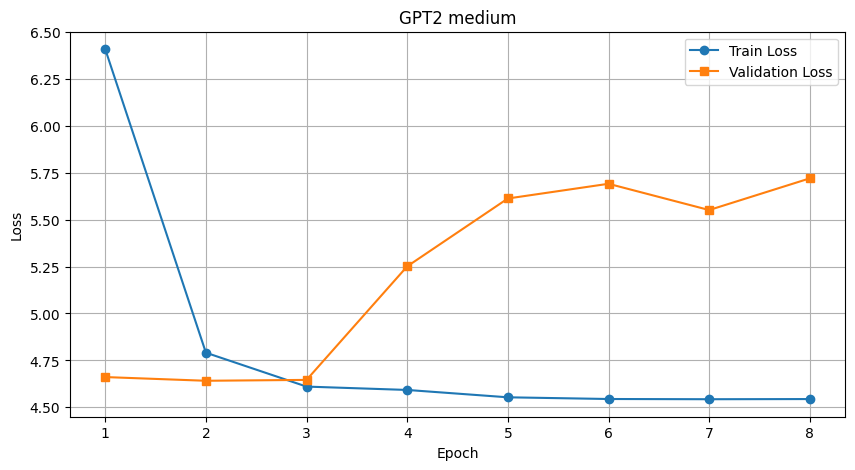

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    optimizer.zero_grad()

    for step, inp``ut_ids in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        input_ids = input_ids.to(device)
        outputs = model(input_ids)
        loss = criterion(outputs.view(-1, vocab_size), input_ids.view(-1)) / gradient_accumulation_steps

        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        train_loss += loss.item() * gradient_accumulation_steps

        if (step + 1) % log_interval == 0:
            avg_train_loss = train_loss / (step + 1)
            print(f"Step [{step+1}/{len(train_loader)}], Train Loss: {avg_train_loss:.4f}")

        del input_ids, outputs, loss
        torch.cuda.empty_cache()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for step, input_ids in enumerate(tqdm(valid_loader, desc=f"Testing Epoch {epoch+1}")):
            input_ids = input_ids.to(device)
            outputs = model(input_ids)
            loss = criterion(outputs.view(-1, vocab_size), input_ids.view(-1))

            valid_loss += loss.item()

            if (step + 1) % log_interval == 0:
                avg_valid_loss = valid_loss / (step + 1)
                print(f"Step [{step+1}/{len(valid_loader)}], Validation Loss: {avg_valid_loss:.4f}")

            del input_ids, outputs, loss
            torch.cuda.empty_cache()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_valid_loss:.4f}")

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")

# Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GPT2 medium")
plt.legend()
plt.grid()
plt.show()